### U-net with simple Resnet Blocks v3, StratifiedKFold 
* Make the validation data distribution more close to train and possibly final test data
* For demonstration only, can use with previous  version or other models to get higher score: 

  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks
  
  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss     
        


In [76]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time

t_start = time.time()

from datetime import datetime

In [77]:
cv_total = 5
#cv_index = 1 -5


basic_name ='Unet_resnet_v5'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v5.model
Unet_resnet_v5.csv


In [78]:
img_size_ori = 101
img_size_target = 101


def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [79]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../dataset/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../dataset/depths.csv", index_col="id")

train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [80]:
train_df["images"] = [np.array(load_img("../dataset/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/araya/.pyenv/versions/3.5.2/envs/py352/lib/python3.5/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [81]:
train_df["masks"] = [np.array(load_img("../dataset/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/araya/.pyenv/versions/3.5.2/envs/py352/lib/python3.5/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


### データセットを観察

In [82]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

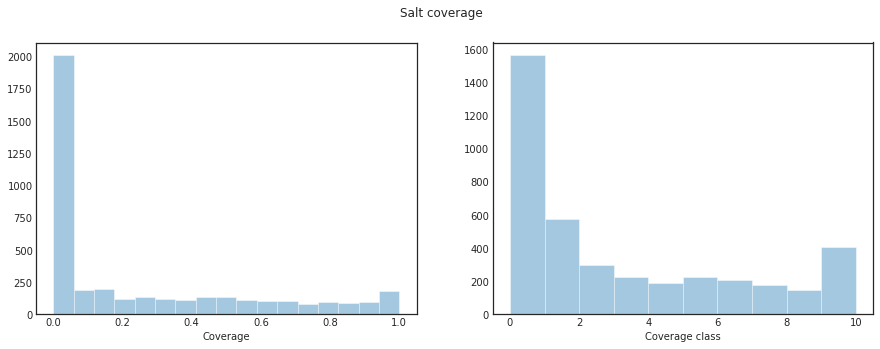

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5,1,'Depth distribution')

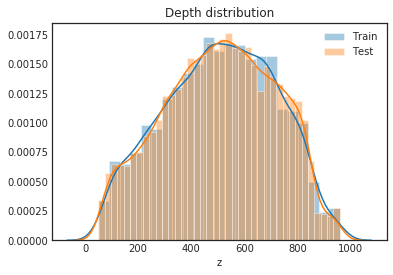

In [84]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

### Data agumentation & preprocessing

In [85]:
# Create train/validation split stratified by salt coverage

_, _, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, 
    stratify=train_df.coverage_class, 
    random_state= 1234)

print("x_train : ", x_train.shape)
print("x_valid : ", x_valid.shape)
print("y_train : ", y_train.shape)
print("y_valid : ", y_valid.shape)
print("cov_train : ", cov_train.shape)
print("cov_test : ", cov_test.shape)
print("depth_train : ", depth_train.shape)
print("depth_test : ", depth_test.shape)

x_train :  (3200, 101, 101, 1)
x_valid :  (800, 101, 101, 1)
y_train :  (3200, 101, 101, 1)
y_valid :  (800, 101, 101, 1)
cov_train :  (3200,)
cov_test :  (800,)
depth_train :  (3200,)
depth_test :  (800,)


In [86]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(y) for y in y_train], axis=0)

print(x_train.shape)
print(y_train.shape)

(6400, 101, 101, 1)
(6400, 101, 101, 1)


### Calculate mask type for stratify, <br>the difficuly of training different mask type is different. 
* Reference  from Heng's discussion, search "error analysis" in the following link

https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657****

#### Show  some examples of different mask

### Model building & Learning

In [87]:
epochs = 2
batch_size = 32

base_dir = "/home/araya/kaggle-tgs-salt"

basic_name ='Unet_resnet_v5' + datetime.now().strftime("__%Y-%m-%d-%H-%M-%S")
log_dir =os.path.join(base_dir, 'train_log', basic_name)

model_csv_path = os.path.join(log_dir, 'my_iou_metric.csv')
model_ckp_path = os.path.join(log_dir, 'model_checkpoint.h5')
model_arch_path = os.path.join(log_dir, 'model_arch.png')

In [88]:
if not os.path.exists(log_dir):
    os.makedirs(log_dir) 

#### build model

In [89]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [90]:
# Build model
def build_model(input_layer, start_filters, DropoutRatio = 0.5):
    
    sf = start_filters
    
    
    ''' Down-Sampling '''
    
    # 101 -> 50
    conv1 = Conv2D(sf * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1, sf * 1)
    conv1 = residual_block(conv1, sf * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(sf * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2, sf * 2)
    conv2 = residual_block(conv2, sf * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(sf * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3, sf * 4)
    conv3 = residual_block(conv3, sf * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(sf * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4, sf * 8)
    conv4 = residual_block(conv4, sf * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    
    ''' Middle '''
    
    convm = Conv2D(sf * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm, sf * 16)
    convm = residual_block(convm, sf * 16, True)
    
    
    ''' Up-Sampling '''
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(sf * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(sf * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4, sf * 8)
    uconv4 = residual_block(uconv4, sf * 8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(sf * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(sf * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3, sf * 4)
    uconv3 = residual_block(uconv3, sf * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(sf * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(sf * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2, sf * 2)
    uconv2 = residual_block(uconv2, sf * 2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(sf * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(sf * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1, sf * 1)
    uconv1 = residual_block(uconv1, sf * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

#### metrics (IoU)

In [95]:
def get_iou_vector(v_true, v_pred):
    v_true = np.squeeze(v_true) 
    v_pred = np.squeeze(v_pred) 
    
    batch_size = v_true.shape[0]
    metric = []    
    
    for batch in range(batch_size):
        
        t,  p = v_true[batch] > 0,  v_pred[batch] > 0
        
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0)  )/ (np.sum(union > 0) )
        thresholds = np.arange(0.5, 1, 0.05)
        
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.0], tf.float64)

In [96]:
# compile model

def build_complie_model(lr = 0.01):
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16, 0.5)

    model_ = Model(input_layer, output_layer)

    opt = optimizers.adam(lr = lr)
    # opt = optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False)
    model_.compile(loss="binary_crossentropy", optimizer=opt, metrics=[my_iou_metric])
    return model_


model = build_complie_model(lr = 0.01)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 101, 101, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 101, 101, 16) 64          conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 101, 101, 16) 0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
conv2d_48 

In [97]:
# callbacks
csv_log = CSVLogger(model_csv_path)

model_checkpoint = ModelCheckpoint(
                                   model_ckp_path,
                                   monitor='my_iou_metric', 
                                   mode = 'max', 
                                   save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
                                   monitor='my_iou_metric', 
                                   mode = 'max',
                                   factor=0.5, 
                                   patience=5, 
                                   min_lr=0.0001, 
                                   verbose=1)


callbacks=[]
callbacks.append(model_checkpoint)
callbacks.append(reduce_lr)
callbacks.append(csv_log)

In [98]:
# model learning
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/2
6400/6400 [==============================] - 102s 16ms/step - loss: 0.3883 - my_iou_metric: 0.4295 - val_loss: 0.7295 - val_my_iou_metric: 0.1451

Epoch 00001: my_iou_metric improved from -inf to 0.42955, saving model to /home/araya/kaggle-tgs-salt/train_log/Unet_resnet_v5__2018-09-26-06-42-43/model_checkpoint.h5
Epoch 2/2
6400/6400 [==============================] - 88s 14ms/step - loss: 0.3077 - my_iou_metric: 0.5258 - val_loss: 0.4974 - val_my_iou_metric: 0.0690

Epoch 00002: my_iou_metric improved from 0.42955 to 0.52575, saving model to /home/araya/kaggle-tgs-salt/train_log/Unet_resnet_v5__2018-09-26-06-42-43/model_checkpoint.h5


In [99]:
from keras.utils import plot_model
plot_model(model, to_file=model_arch_path, show_shapes=True)

In [100]:
def plot_history(history, metric_name):
    fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15, 5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_score.plot(history.epoch, history.history[metric_name], label="Train score")
    ax_score.plot(history.epoch, history.history["val_" + metric_name], label="Validation score")
    ax_score.legend()

# predict both orginal and reflect x
def predict_result(model,x_test, img_size_target): 
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

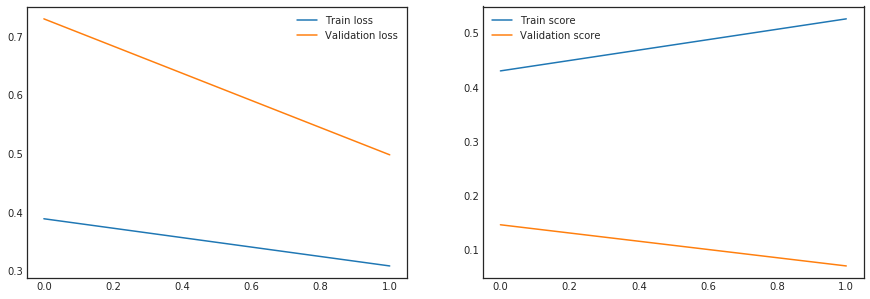

In [101]:
plot_history(history, 'my_iou_metric')



In [102]:
model.load_weights(model_ckp_path)

In [103]:
preds_valid = predict_result(model,x_valid, img_size_target)

In [113]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
    intersection = temp1[0]
    
    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [114]:
## Scoring for last model, choose threshold by validation data 

thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori / (1 - thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.133125 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125
 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125 0.133125
 0.155875 0.157375 0.169625 0.157875 0.14     0.118125 0.10275  0.0905
 0.0715   0.12775  0.2425   0.31725  0.358125 0.3825   0.391   ]


In [118]:
ious.shape

(31,)

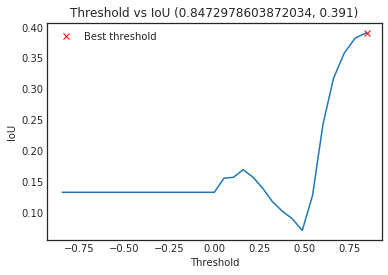

In [115]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [119]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one

"""



def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [120]:
x_test = np.array([(np.array(load_img("../dataset/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

/home/araya/.pyenv/versions/3.5.2/envs/py352/lib/python3.5/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [121]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)


for cv_index in range(cv_total):
    basic_name = f'Unet_resnet_v5_cv{cv_index+1}'
    model.load_weights(basic_name + '.model')
    preds_test += predict_result(model,x_test,img_size_target) /cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

SyntaxError: invalid syntax (<ipython-input-121-7d579b7cda3d>, line 5)

In [ ]:

t1 = time.time()
threshold  = 0.5 # some value in range 0.4- 0.5 may be better 
pred_dict = {idx: rle_encode(np.round(preds_test[i]) > threshold) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [ ]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")